# Sequence to Sequence Modelling

**Note**: All code should be in Python3. Keras version should be 2.0.4. 

![title](seq2seq.png)

In this assignment, we are going to solve the problem of summarization using a sequence to sequence model. In a sequence to sequence problem, we have an encoder and a decoder. We feed the sequence of word embeddings to an encoder and train decoder to learn the summaries. We will be seeing 2 types of encoder decoder architectures in this assignment

# Preparing Inputs

The first part of the assignment is to prepare data. You are given training data in train_article.txt, in which each line is the first sentence from an article, and training summary sentences in train_title.txt, which are the corresponding titles of the article. You will be training the model to predict the title of an article given the first sentence of that article, where title generation is a summarization task. Let us limit the maximum vocabulary size to 20000 and maximum length of article to 200 (These are just initial params to get you started and we recommend experimenting, to improve your scores after you are done with your first implementation)

In [257]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17527871406151950625
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 288489472
locality {
  bus_id: 1
}
incarnation: 10307884410199990465
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [258]:
from keras.preprocessing.text import text_to_word_sequence
from keras.models import Sequential
from keras.layers import Activation, TimeDistributed, Dense, RepeatVector, recurrent, Embedding
from keras.layers.recurrent import LSTM
from keras.optimizers import Adam, RMSprop
from nltk import FreqDist
import numpy as np
import os
import datetime
from keras.preprocessing import sequence
import operator
from keras.preprocessing.sequence import pad_sequences
import keras
import rouge
from keras.models import load_model
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping

In [259]:
MAX_LEN = 200
VOCAB_SIZE = 20000

Write a function which takes article file, summary file, maximum length of sentence and vocabulary size and does the following
* Create vocabulary: Take most frequent VOCAB_SIZE number of words from article file. Add two special symbols ZERO at start and UNK at end to finally have VOCAB_SIZE + 2 words. Use this array as idx2word. Repeat the process for summary data to create another idx2word corresponding to it. 
* Using the above idx2word for both article and summary data, create word2idx, which will map every word to its index in idx2word array. 
* Convert the words in the article and summary data to their corresponding index from word2idx. If a word is not present in the vocab, use the index of UNK. 
* After the above preprocessing, each sentence in article and summary data should be a list of indices
* Now find the max length of a sentence (which is basically number of indices in a sentence) in article data. Pad every sentence in article data to that length, so that all sentences are of same length. You may use pad_sequences function provided by keras. Do the same for title data.
* return the following outputs transformed article data, vocab size of article data, idx2word(articledata), word2idx(articledata),transformed summary data, vocab size of summary data, idx2word(summarydata), word2idx(summarydata)

In [260]:
def load_data(article, summary, max_len, vocab_size):
    
    #reading in data from files
    articles = []
    titles = []
    
    f = open(article, 'r')
    for line in f:
        articles.append(line.strip())
    f.close()

    f = open(summary,'r')
    for line in f:
        titles.append(line.strip())
    f.close()  
        
    #filter out all pairs where length of article/summary > 200 words
    articles_filt = []
    titles_filt = []
    
    for i in range(len(articles)):
        if len(articles[i]) <= MAX_LEN and len(titles[i]) <= MAX_LEN:
            articles_filt.append(articles[i])
            titles_filt.append(titles[i])
            
    #convert text to list of words
    articles = []
    titles = []
    
    for i in range(len(articles_filt)):
        articles.append(text_to_word_sequence(articles_filt[i], filters = '\t\n'))
        titles.append(text_to_word_sequence(titles_filt[i], filters = '\t\n'))
        
    
    #finding most common words
    mcwa = FreqDist(np.hstack(articles))
    vocab_articles = mcwa.most_common(vocab_size)
    mcwt = FreqDist(np.hstack(titles))
    vocab_titles = mcwt.most_common(vocab_size)
    
    vocab_articles_len = len(vocab_articles) + 2
    vocab_titles_len = len(vocab_titles) + 2
    
    #creating idx2word for articles
    
    idx2word_articles = {}
    
    
    for i in range(len(vocab_articles)):
        idx2word_articles[i+1] = vocab_articles[i][0]
        
    idx2word_articles[0] = 'ZERO'
    idx2word_articles[vocab_size+1] = 'UNK'
 

    #creating word2idx for articles
    
    word2idx_articles = {}
    
    for k,v in idx2word_articles.items():
        word2idx_articles[v] = k
        
        
    #creating idx2word for titles
    
    idx2word_titles = {}
    
    
    for i in range(len(vocab_titles)):
        idx2word_titles[i+1] = vocab_titles[i][0]
        
    idx2word_titles[0] = 'ZERO'
    idx2word_titles[vocab_size+1] = 'UNK'
 

    #creating word2idx for titles
    
    word2idx_titles = {}
    
    for k,v in idx2word_titles.items():
        word2idx_titles[v] = k
        
        
    #creating sequences for articles
    
    seq_articles = []
    seq_titles = []
    
    
    for i in range(len(articles)):
        seq_articles.append([])
        for j in articles[i]:
            
            if j == '<unk>':
                seq_articles[i].append(word2idx_articles['UNK'])
            elif j in word2idx_articles.keys():
                seq_articles[i].append(word2idx_articles[j])
            else:
                seq_articles[i].append(word2idx_articles['UNK'])
    
                
    #creating sequences for titles          
    for i in range(len(titles)):
        seq_titles.append([])
        for j in titles[i]:
            
            if j == '<unk>':
                seq_titles[i].append(word2idx_titles['UNK'])
                
            elif j in word2idx_titles.keys():
                seq_titles[i].append(word2idx_titles[j])
            else:
                seq_titles[i].append(word2idx_titles['UNK'])
                
                
                
    #maxlen of articles
    
    maxlen_articles = 0
    for i in seq_articles:
        if len(i) > maxlen_articles:
            maxlen_articles = len(i)            
            
    #maxlen of titles
    
    maxlen_titles = 0
    for i in seq_titles:
        if len(i) > maxlen_titles:
            maxlen_titles = len(i)
            
    seq_articles = sequence.pad_sequences(seq_articles, maxlen=20, dtype='int32', value = 0, padding = 'post', truncating= 'post')
    seq_titles = sequence.pad_sequences(seq_titles, maxlen=20, dtype='int32', value = 0, padding='post', truncating='post')
    
    return seq_articles,vocab_articles_len, word2idx_articles, idx2word_articles, seq_titles, vocab_titles_len, word2idx_titles,idx2word_titles   
                

Now use the above function to load the training data from article and summary (i.e. title) files. Do note that, based on your model architecture, you may need to further one-hot vectorize your input to the model

In [261]:
# TO-DO
seq_articles, vocab_articles_len, word2idx_articles,idx2word_articles, seq_titles, vocab_titles_len, word2idx_titles, idx2word_titles= load_data('data/train_article.txt', 'data/train_title.txt' ,MAX_LEN, VOCAB_SIZE)

# Unidirectional LSTM Encoder Decoder 

Define the parameters for your LSTM encoder decoder model. 

In [262]:
maxlen_articles = len(seq_articles[0])
maxlen_titles = len(seq_titles[0])
print(maxlen_articles)
print(maxlen_titles)

20
20


In [263]:
BATCH_SIZE = 500
NUM_LAYERS = 2
HIDDEN_DIM = 150
EPOCHS = 200

Create a Unidirectional encoder decoder LSTM model in create_model function. The model should have a LSTM Unidirectional layer as encoder and a LSTM decoder.
Use categorical_cross_entropy loss and experiment with different optimizers to improve your score.

In [264]:
def create_UniLSTM(X_vocab_len, X_max_len, y_vocab_len, y_max_len, hidden_size, num_layers):
    model = Sequential()

    # Creating encoder network
    model.add(Embedding(input_dim = X_vocab_len, output_dim = HIDDEN_DIM, input_length=X_max_len, mask_zero=True))
    model.add(LSTM(hidden_size))
    model.add(RepeatVector(y_max_len))

    # Creating decoder network
    for i in range(num_layers):
        model.add(LSTM(units = hidden_size, return_sequences=True, unroll = True))
    model.add((Dense(y_vocab_len)))
    model.add(Activation(activation = 'softmax'))
    model.compile(loss='sparse_categorical_crossentropy',optimizer='rmsprop', metrics=['accuracy'])
    print(model.summary())
    return model


In [265]:
vocab_articles_len

20002

In [266]:
vocab_titles_len

20002

In [318]:
model = create_UniLSTM(vocab_articles_len, maxlen_articles, vocab_titles_len, maxlen_titles, HIDDEN_DIM, NUM_LAYERS)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 20, 150)           3000300   
_________________________________________________________________
lstm_10 (LSTM)               (None, 150)               180600    
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 20, 150)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 20, 150)           180600    
_________________________________________________________________
lstm_12 (LSTM)               (None, 20, 150)           180600    
_________________________________________________________________
dense_2 (Dense)              (None, 20, 20002)         3020302   
_________________________________________________________________
activation_2 (Activation)    (None, 20, 20002)         0         
Total para

# Train the Model

Now that we have everything in place, we can run our model. We recommend training the model in batches instead of training on all 50,000 article-title pairs at once, if you encounter memory contraints

In [ ]:
X = seq_articles
y = seq_titles

In [ ]:
wt_dir = "weights2/basic/"
bst_model_path = wt_dir + "model-2-layers-{epoch:02d}-{val_acc:.4f}" + '.h5'
model_checkpoint = ModelCheckpoint(bst_model_path, monitor='val_acc', save_best_only= False, save_weights_only=True)

In [ ]:
model.fit(X, np.reshape(y, [50000, 20,1]), epochs = EPOCHS, validation_split = 0.2,batch_size = BATCH_SIZE ,verbose = 1,callbacks = [model_checkpoint])

In [319]:
model.load_weights('weights2/basic/model-2-layers-55-0.6312.h5')

# Evaluation using Rouge score 

Now that you have trained the model, load the test data i.e. test_article.txt and corresponding reference titles test_title.txt. Process test_article.txt in the same way as you did your train_article.txt. Then use your model to predict the titles.
When you have your model predicted titles, and the reference titles (test_title.txt) calculate the Rouge score corresponding to your predictions. <br>
You should install rouge by executing "pip3 install rouge". Refer https://pypi.python.org/pypi/rouge/0.2.1 for documentation on how to use the package.

In [320]:
def process_test_data(article, summary, max_len, word2idx, idx2word):
    
    #reading in data from files
    articles = []
    titles = []
    articles_orig = []
    
    f = open(article, 'r')
    for line in f:
        articles.append(line.strip())
    f.close()
    articles_orig = articles

    f = open(summary,'r')
    for line in f:
        titles.append(line.strip())
    f.close()  
    
    
    print('No. of articles in test set: ',len(articles))
    print('No. of titles in test set: ',len(titles))
    
    #filter out all pairs where length of article/summary > 200 words
    
    articles_filt = []
    titles_filt = []
    
    for i in range(len(articles)):
        if len(articles[i]) <= 200 and len(titles[i]) <= 200:
            articles_filt.append(articles[i])
            titles_filt.append(titles[i])
            
    #convert text to list of words
    
    articles = []
    titles = []
    
    for i in range(len(articles_filt)):
        articles.append(text_to_word_sequence(articles_filt[i]))
        titles.append(text_to_word_sequence(titles_filt[i]))
            
    #creating sequences for articles
    
    seq_articles = []
    
    for i in range(len(articles)):
        seq_articles.append([])
        for j in articles[i]:
            if j == '<unk>':
                seq_articles[i].append(word2idx['UNK'])
            elif j in word2idx.keys():
                seq_articles[i].append(word2idx[j])
            else:
                seq_articles[i].append(word2idx['UNK'])
               
                
    seq_articles = sequence.pad_sequences(seq_articles, maxlen=maxlen_articles, dtype='int32', value = 0, padding = 'post')
    
    return seq_articles, titles,articles_orig
                
    

In [321]:
X_test, y_test, articles_orig = process_test_data('data/test_article.txt', 'data/test_title.txt',20, word2idx_articles, idx2word_articles)

No. of articles in test set:  7000
No. of titles in test set:  7000


In [322]:
#generate summaries for the test data
preds = model.predict(X_test)

preds_f = []

for i in range(0,len(preds)):
    word_p = []
    for j in preds[i]:
        if idx2word_titles[np.argmax(j)] == 'ZERO':
            break
        else:
            word_p.append(idx2word_titles[np.argmax(j)])
    
    preds_f.append(word_p)

In [323]:
#string outputs into strings
final_preds = []
final_test = []

for i in preds_f:
    final_preds.append(" ".join(i))
    
for i in y_test:
    final_test.append(" ".join(i))

In [324]:
import rouge

In [325]:
rouge = rouge.Rouge()
scores = rouge.get_scores(final_preds, final_test, avg = True)

In [326]:
scores

{'rouge-1': {'f': 0.065278884815704014,
  'p': 0.10576292517006804,
  'r': 0.050070733864641427},
 'rouge-2': {'f': 0.0052492447105385257,
  'p': 0.0057901360544217696,
  'r': 0.0049959286745001026},
 'rouge-l': {'f': 0.049676226022368611,
  'p': 0.064158854637426058,
  'r': 0.048936146661461788}}

# Tensorboard Visualization 

We recommended training the data in batches because of our tensor constraints. This also presents us with a challenge of visualizing loss function and accuracy change with each epoch. Keras has an inbuilt function called fit_generator which takes in a generator function and gives the required batch for training. Use this Function to load data in batches of 100 for 200 steps_per_epoch. Run the training for 10 epochs. Use Keras callbacks to send data to tensorboad (you can look this up online). 

Once your training is done. Go to command line and run tensorboard. By default Tensorboard opens on 6006 port. Do remember to allow traffic on the same for gcloud (like you did for previous assignment). You can see various metrics depending on what you want to track like loss, accuracy, validation loss and validation accuracy over epochs. Attach the plots of loss and accuracy from the tensorboard display in the notebook

In [ ]:
# TO-DO

def my_generator(batch_size):
    features = seq_articles
    labels = np.reshape(seq_titles, (50000,maxlen_titles,1))   
    while (1):
        possible_Indices = np.arange(len(seq_titles)-1)
        np.random.shuffle(possible_Indices)
        sampling_Indices = possible_Indices[:batch_size]
        yield (features[sampling_Indices],labels[sampling_Indices])

In [331]:
tbCallBack = keras.callbacks.TensorBoard(log_dir='./tboard', histogram_freq=0, write_graph=True, write_images=True)
model.fit_generator(generator = my_generator(100),steps_per_epoch=200, epochs =10, verbose =1, callbacks = [tbCallBack])

200/200 [==============================] - 54s - loss: 2.6368 - acc: 0.6599    
Epoch 2/10
200/200 [==============================] - 53s - loss: 2.6321 - acc: 0.6595    
Epoch 3/10
200/200 [==============================] - 53s - loss: 2.6269 - acc: 0.6598    
Epoch 4/10
200/200 [==============================] - 53s - loss: 2.5949 - acc: 0.6613    
Epoch 5/10
200/200 [==============================] - 54s - loss: 2.5862 - acc: 0.6621    
Epoch 6/10
200/200 [==============================] - 54s - loss: 2.5673 - acc: 0.6629    
Epoch 7/10
200/200 [==============================] - 54s - loss: 2.5351 - acc: 0.6658    
Epoch 8/10
200/200 [==============================] - 54s - loss: 2.5313 - acc: 0.6651    
Epoch 9/10
200/200 [==============================] - 54s - loss: 2.5275 - acc: 0.6656    
Epoch 10/10
200/200 [==============================] - 54s - loss: 2.5001 - acc: 0.6674    


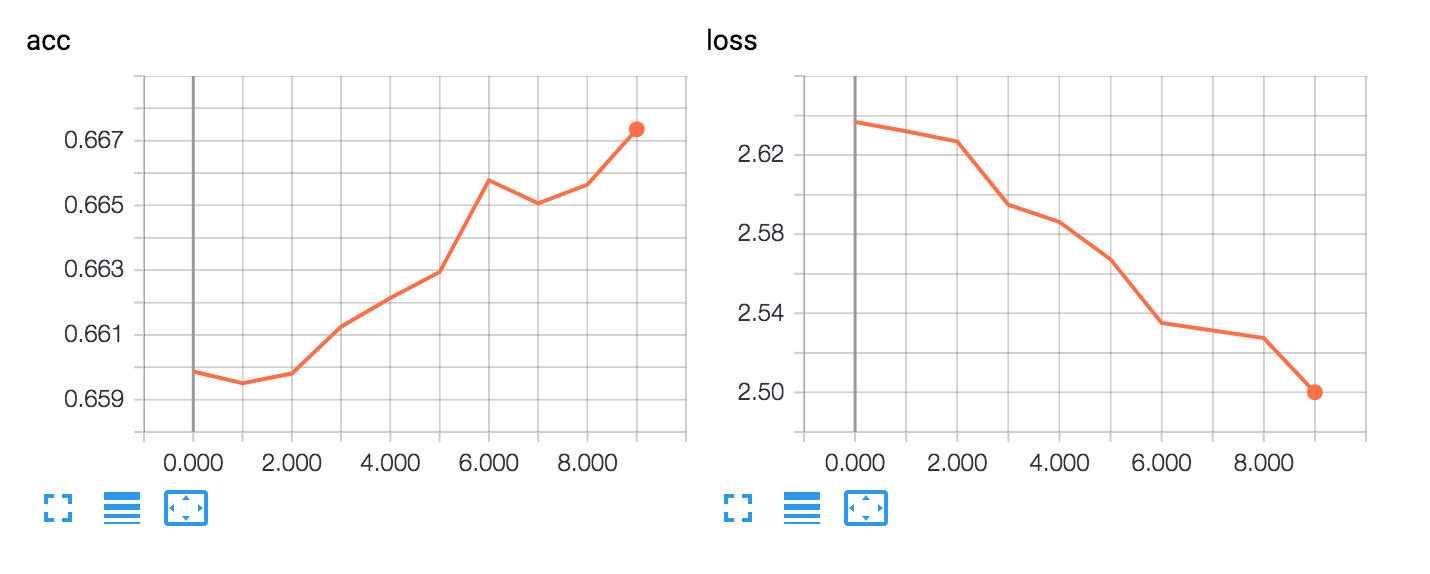

In [1]:
from IPython.display import Image
Image(filename='tboard.png')

# Unidirectional LSTM Encoder Decoder With Attention 

Define the parameters for your LSTM encoder decoder model with attention

In [64]:
BATCH_SIZE = 500
NUM_LAYERS = 1
HIDDEN_DIM = 100
EPOCHS = 50

In [45]:
VOCAB_SIZE = 5000

You would've observed that the summaries are not yet perfect. This is because in encoder decoder architecture, only the final state of encoder is used to calculate the probabilities. We now move to a more general approach called attention based approach. In this, we take a weighted sum of all weights of encoder instead of just the last one. You are already provided an attention_decoder.py file with AttentionDecoder. Add this layer on top of your encoder and run the same experiment as before. For this part, you don't need to worry about return_probabilities argument to create_UniLSTMwithAttention function. Just pass it as an argument to your attention decoder layer. When return_probabilities is false, the attention decoder returns prediction model, which is what you need for this part of the assignment. When return_probabilities is true, the attention decoder returns the probability model, which you will be using later in the Analysis part of this assignment

In [46]:
from attention_decoder import AttentionDecoder

In [47]:
def create_UniLSTMwithAttention(X_vocab_len, X_max_len, y_vocab_len, y_max_len, hidden_size, num_layers, return_probabilities = False):
    # create and return the model for unidirectional LSTM encoder decoder with attention
    
    model = Sequential()

    # Creating encoder network
    model.add(Embedding(input_dim = X_vocab_len, output_dim = HIDDEN_DIM, input_length=X_max_len, mask_zero=True))
    model.add(LSTM(hidden_size, return_sequences=True))

        
    model.add(AttentionDecoder(hidden_size, 5002))
    
    model.compile(loss='sparse_categorical_crossentropy',optimizer='rmsprop', metrics=['accuracy'])
    print(model.summary())
    return model
    
    return

# Train the Model

Train the model, as you did before, for the model without attention

In [250]:
# TO-DO
seq_articles, vocab_articles_len, word2idx_articles,idx2word_articles, seq_titles, vocab_titles_len, word2idx_titles, idx2word_titles= load_data('data/train_article.txt', 'data/train_title.txt' ,MAX_LEN, VOCAB_SIZE)

In [251]:
maxlen_articles = len(seq_articles[0])
maxlen_titles = len(seq_titles[0])
print(maxlen_articles)
print(maxlen_titles)

20
20


In [252]:
vocab_articles_len

5002

In [253]:
X = seq_articles
y = seq_titles

In [52]:
model1 = create_UniLSTMwithAttention(vocab_articles_len, maxlen_articles, vocab_titles_len, maxlen_titles, HIDDEN_DIM, NUM_LAYERS)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 20, 100)           500200    
_________________________________________________________________
lstm_5 (LSTM)                (None, 20, 100)           80400     
_________________________________________________________________
AttentionDecoder (AttentionD (None, 20, 5002)          27616506  
Total params: 28,197,106
Trainable params: 28,197,106
Non-trainable params: 0
_________________________________________________________________
None


In [65]:
wt_dir = "weights2/attn3/"
bst_model_path = wt_dir + "weights-improvement-attn-1.3-layer-{epoch:02d}-{val_acc:.4f}-{val_loss:.4f}" + '.h5'
model_checkpoint = ModelCheckpoint(bst_model_path, monitor='val_acc', save_best_only=True, save_weights_only=True)

In [327]:
model1.fit(X, np.reshape(y, [50000, 20,1]), epochs = 50, validation_split = 0.2, batch_size = BATCH_SIZE ,verbose = 1, callbacks= [model_checkpoint])

In [69]:
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 20, 100)           500200    
_________________________________________________________________
lstm_5 (LSTM)                (None, 20, 100)           80400     
_________________________________________________________________
AttentionDecoder (AttentionD (None, 20, 5002)          27616506  
Total params: 28,197,106
Trainable params: 28,197,106
Non-trainable params: 0
_________________________________________________________________


# Evaluation using Rouge Score

Evaluate your model as before, using Rouge score. Ideally, your scores for the model with attention should be better than the model without attention

In [289]:
X_test, y_test, articles_orig = process_test_data('data/test_article.txt', 'data/test_title.txt',20, word2idx_articles, idx2word_articles)

No. of articles in test set:  7000
No. of titles in test set:  7000


In [290]:
#generate summaries for the test data
preds = model1.predict(X_test)

preds_f = []

for i in range(0,len(preds)):
    word_p = []
    for j in preds[i]:
        if idx2word_titles[np.argmax(j)] == 'ZERO':
            break
        else:
            word_p.append(idx2word_titles[np.argmax(j)])
    
    preds_f.append(word_p)

In [291]:
#string outputs into strings
final_preds = []
final_test = []

for i in preds_f:
    final_preds.append(" ".join(i))
    
for i in y_test:
    final_test.append(" ".join(i))

In [292]:
import rouge

In [87]:
rouge = rouge.Rouge()
scores = rouge.get_scores(final_preds, final_test, avg = True)

In [88]:
scores

{'rouge-1': {'f': 0.11077596844483069,
  'p': 0.15798979591836734,
  'r': 0.093017467173349522},
 'rouge-2': {'f': 0.038936576584988974,
  'p': 0.042298129251700678,
  'r': 0.037519502719502724},
 'rouge-l': {'f': 0.091368213796535522,
  'p': 0.10195813710099423,
  'r': 0.09184560683247657}}

# Perplexity 

Even though we evaluate our models on ROUGE score, we don't train our neural networks to learn better ROUGE score for the fact that ROUGE score is a complicated nonconvex function. How does our model learn then? In information theory, Perplexity is a measure of how good a model is.

Perplexity                     $$ = 2^{{-\sum _{x}p(x)\log _{2}p(x)}}$$ 
            
Lower the perplexity, better the model. Justify why our model learns well with our loss function? 

#### Why model learns well with loss function?



Perplexity is the of how well a probability distribution or probability model predicts a sample. It is used to compare different language models. A low perplexity indicates the probability distribution is good at predicting the sample. The perplexity of a discrete probability distribution p is defined as $$ = 2^{{H(p)}}$$
where ${{H(p)}}$ is the entropy (in bits) of the distribution and x ranges over events. In our models we are trying to minimize the categorical crossentropy. The cross entropy between two probability distributions $p$  and $q$ over the same underlying set of events measures the average number of bits needed to identify an event drawn from the set, if a coding scheme is used that is optimized for an "unnatural" probability distribution  q, rather than the "true" distribution p.

The exponent in the perplexity equation may also be regarded as a cross-entropy,
 $$ = 2^{{-\sum _{x}p(x)\log _{2}q(x)}}$$ 

where $p$ denotes the empirical distribution of the test sample (i.e., $p(x)=n/N$ if $x$ appeared $n$ times in the test sample of size $N$)

This is a multi-class problem so we use categorical cross-entropy. As cross entropy goes down, the model perplexity goes down and thus the model learns well.

In [109]:
model1_pred = model1

In [110]:
model1_pred.load_weights('weights2/attn3/weights-improvement-attn-1.3-layer-26-0.6148-2.7186.h5')

### Best sentences

In [205]:
#used to find good summaries
from nltk import edit_distance
ed = []

for i in range(len(final_preds)):
    ed.append(edit_distance(final_preds[i], final_test[i]))
    
l = np.argsort(ed)

# Analysis

You will now plot the attention weights for a sentence and it's output. If a grid cell is white in the plot, it means that during summary, the word on x-axis corresponds to the word on y-axis. You are provided with a Visualizer class for helping you out. Make sure you install matplotlib using sudo pip3 install matplotlib and also install python3-tk using sudo apt-get install python3-tk

In [204]:
# !sudo apt-get install python3-tk

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-tk is already the newest version (3.5.1-1).
python3-tk set to manually installed.
The following packages were automatically installed and are no longer required:
  linux-image-4.4.0-101-generic linux-image-extra-4.4.0-101-generic
Use 'sudo apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.


In [118]:
import argparse
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

In [334]:
class Visualizer(object):

    def __init__(self):
        """
            Visualizes attention maps
        """
        
        
    def set_models(self, pred_model, proba_model):
        """
            Sets the models to use
            :param pred_model: the prediction model
            :param proba_model: the model that outputs the activation maps
        """
        self.pred_model = pred_model
        self.proba_model = proba_model

    def attention_map(self, text, padded_data_vec, y_idx_to_word):
        """
            Displays the attention weights graph
            param: input sentence
            param: padded_data_vector for prediction
            param: idx2word dictionary for titles
        """
        input_length = len(text.split())
        
        # get the output sequence
        
        prediction = np.argmax(pred_model.predict([padded_data_vec]), axis=2)[0]
        
#         print(prediction)
    
        text_ = text.split()
        valids = [y_idx_to_word[index] for index in prediction if index > 0]
        
        
        sequence = ' '.join(valids)

        #sequence = final_preds[0]
        
        predicted_text = sequence.split()
        output_length = len(predicted_text)
        #get the weights
        activation_map = np.squeeze(self.proba_model.predict(padded_data_vec))[0:output_length, 0:input_length]
        
        plt.clf()
        f = plt.figure(figsize=(8, 8.5))
        ax = f.add_subplot(1, 1, 1)

        # add image
        i = ax.imshow(np.log(activation_map), interpolation='nearest', cmap='gray')        
        # add colorbar
        cbaxes = f.add_axes([0.2, 0, 0.6, 0.03])
        cbar = f.colorbar(i, cax=cbaxes, orientation='horizontal')
        cbar.ax.set_xlabel('Probability', labelpad=2)

        # add labels
        ax.set_yticks(range(output_length))
        ax.set_yticklabels(predicted_text[:output_length])
        
        ax.set_xticks(range(input_length))
        ax.set_xticklabels(text_[:input_length], rotation=45)
        
        ax.set_xlabel('Input Sequence')
        ax.set_ylabel('Output Sequence')

        # add grid and legend
        ax.grid()
        
        f.show()

You can initialize Visualizer class as follows

In [335]:
viz = Visualizer()

Visualizer has two methods.
- set_models 
- attention_map

The set_models takes in prediction model and probability model as inputs. In *create_UniLSTMwithAttention*, the model with *return_probabilities = False* which you already used in the training is the prediction model. For initializing probability model, call *create_UniLSTMwithAttention* with *return_probabilities = True* and initialize the weights with weights of prediction model. Now you can call set_models in this manner:

In [210]:
model1_prob = create_UniLSTMwithAttention(vocab_articles_len, maxlen_articles, vocab_titles_len, maxlen_titles, HIDDEN_DIM, NUM_LAYERS, return_probabilities = True)

In [211]:
model1_prob.load_weights('weights2/attn3/weights-improvement-attn-1.3-layer-26-0.6148-2.7186.h5')

In [336]:
pred_model = model1_pred
prob_model = model1_prob

In [337]:
viz.set_models(pred_model,prob_model)

attention_map creates the weights map for you. You need to give a sample sentence, a test_data_vector on which we call call model.predict and your output idx2word dictionary. You can call it as follows

In [214]:
#viz.attention_map(text,test_data_vector,idx2word)

Use the above Visualizer to visualize attention weights for 15 sentences, as instructed in the Analysis section of the accompanying HW document

In [217]:
%matplotlib inline

[6497, 6764, 427, 6725, 6726, 6484, 1827, 1830, 4156, 1631, 1710, 3407, 4216, 1131, 1824]
True title:  german stocks open lower


/usr/lib/python3/dist-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


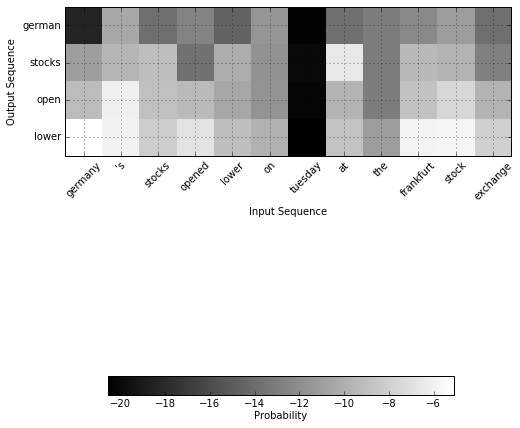

True title:  thailand financial markets closed


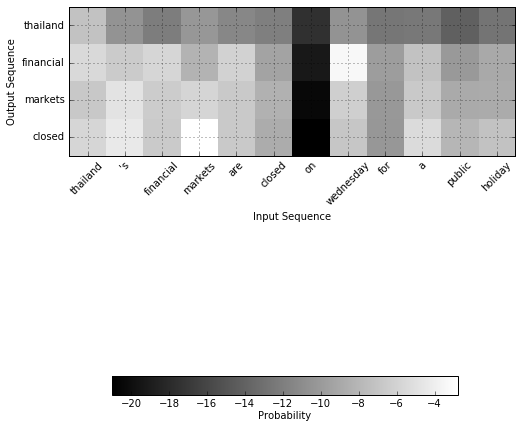

True title:  share prices close lower


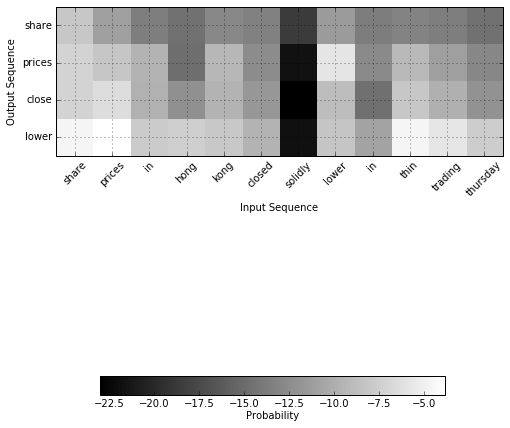

True title:  greek stocks close higher


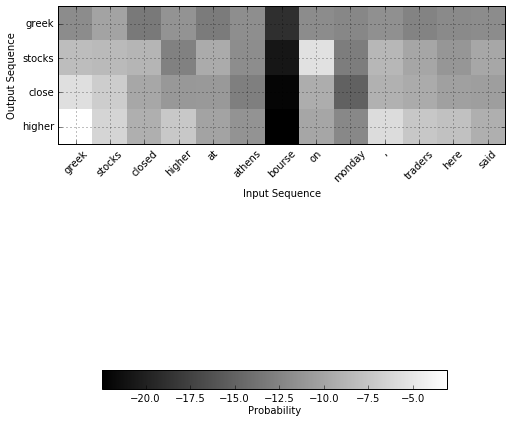

True title:  german stocks open higher


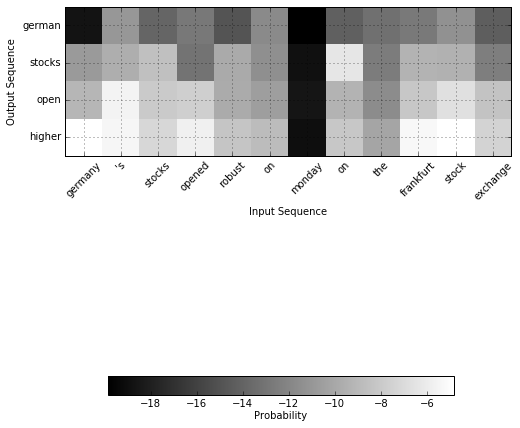

True title:  stocks close higher in mexico brazil


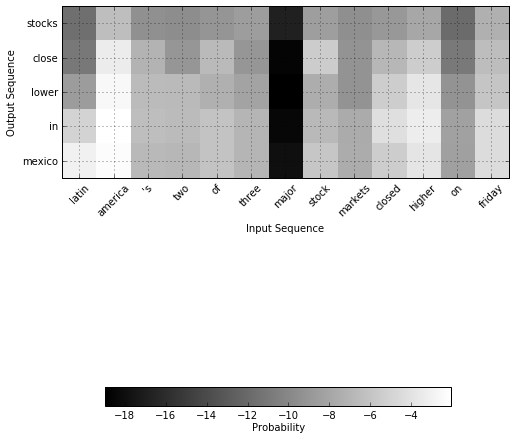

True title:  dollar at lower yen level in tokyo


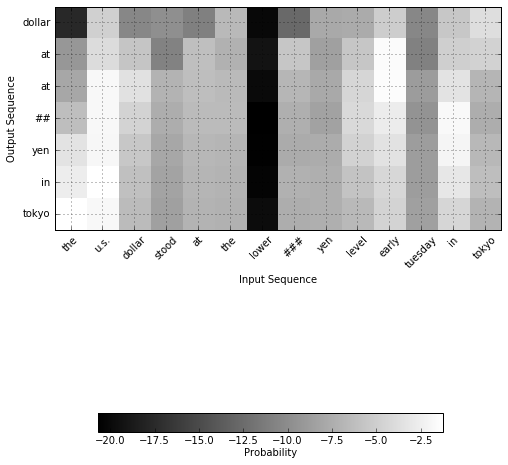

True title:  stocks close lower in argentina brazil


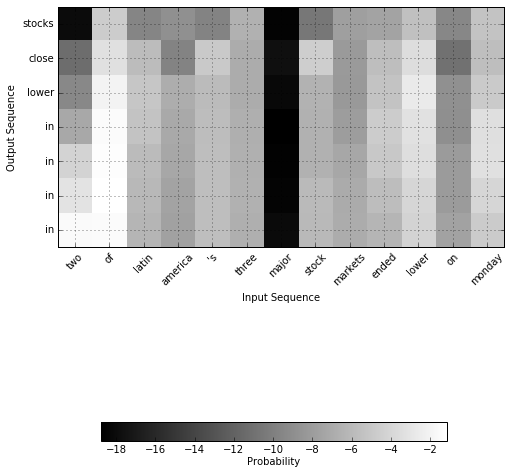

True title:  dollar at upper yen in tokyo


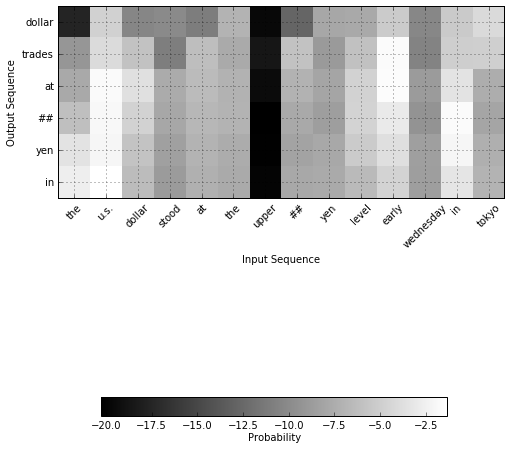

True title:  chinext index opens lower friday


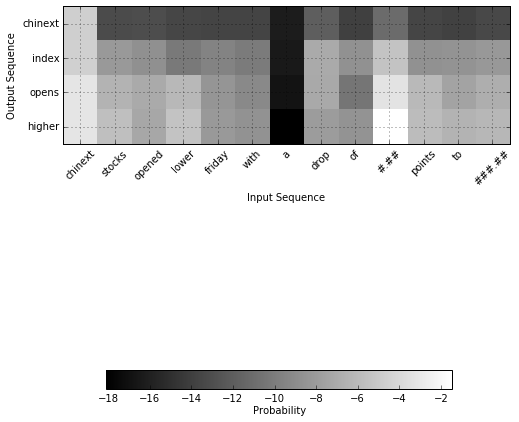

True title:  dollar rises to lower yen range


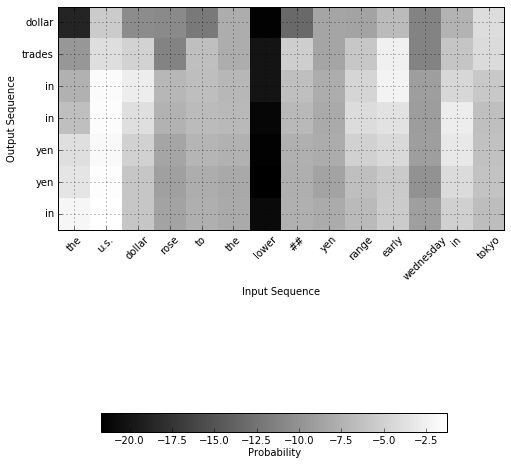

True title:  bruschi means unk


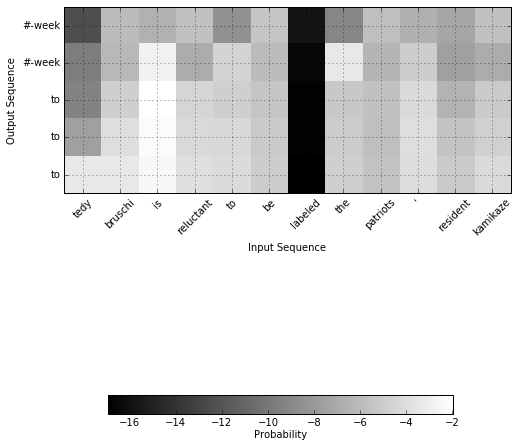

True title:  london key market information


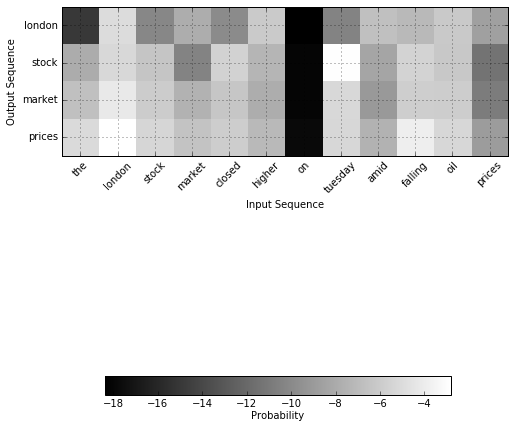

True title:  northridge edges idaho state


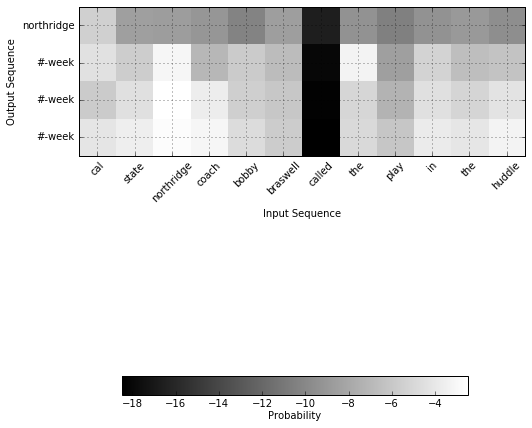

True title:  stocks closed lower in mexico brazil


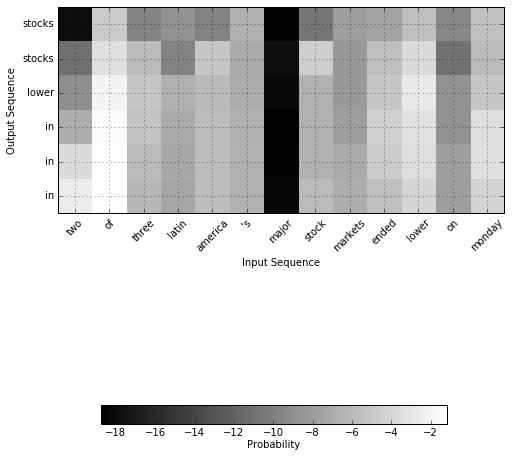

In [338]:
# Choosing examples based on edit distance

ind = list(l[:5]) + list( l[-6800:-6795] )+ list(l[-6650:-6645])
print(ind)

true_tit = []
lstm_a_pred = []
art = []
lstm_pred = []


for i in (ind):
    
    plt.figure()
    print('True title: ',' '.join(y_test[i]))
    
    true_tit.append(' '.join(y_test[i]))
    lstm_a_pred.append(final_preds[i])
    art.append(articles_orig[i])
    viz.attention_map(articles_orig[i][:-1], np.reshape(X_test[i], (1,20)), idx2word_titles)
    plt.show()

In [313]:
true_tit = []
lstm_a_pred = []
art = []
lstm_pred = []


for i in (ind):
    
    true_tit.append(' '.join(y_test[i]))
    lstm_a_pred.append(final_preds[i])
    art.append(articles_orig[i])

In [314]:
true_tit

['german stocks open lower',
 'thailand financial markets closed',
 'share prices close lower',
 'greek stocks close higher',
 'german stocks open higher',
 'stocks close higher in mexico brazil',
 'dollar at lower yen level in tokyo',
 'stocks close lower in argentina brazil',
 'dollar at upper yen in tokyo',
 'chinext index opens lower friday',
 'dollar rises to lower yen range',
 'bruschi means unk',
 'london key market information',
 'northridge edges idaho state',
 'stocks closed lower in mexico brazil']

In [315]:
art

["germany 's stocks opened lower on tuesday at the frankfurt stock exchange .",
 "thailand 's financial markets are closed on wednesday for a public holiday .",
 'share prices in hong kong closed solidly lower in thin trading thursday .',
 'greek stocks closed higher at athens bourse on monday , traders here said .',
 "germany 's stocks opened robust on monday on the frankfurt stock exchange .",
 "latin america 's two of three major stock markets closed higher on friday .",
 'the u.s. dollar stood at the lower ### yen level early tuesday in tokyo .',
 "two of latin america 's three major stock markets ended lower on monday .",
 'the u.s. dollar stood at the upper ## yen level early wednesday in tokyo .',
 'chinext stocks opened lower friday with a drop of #.## points to ###.## .',
 'the u.s. dollar rose to the lower ## yen range early wednesday in tokyo .',
 "tedy bruschi is reluctant to be labeled the patriots ' resident kamikaze .",
 'the london stock market closed higher on tuesday 

In [316]:
lstm_a_pred

['german stocks open lower',
 'thailand financial markets closed',
 'share prices close lower',
 'greek stocks close higher',
 'german stocks open higher',
 'stocks close lower in mexico',
 'dollar at at ## yen in tokyo',
 'stocks close lower in in in in',
 'dollar trades at ## yen in',
 'chinext index opens higher',
 'dollar trades in in yen yen in',
 '#-week #-week to to to',
 'london stock market prices',
 'northridge #-week #-week #-week',
 'stocks stocks lower in in in']

# ANALYSIS

**Select 15 article/summary pairs from your final attention model for an error analysis. Choose 5 that you
think are good and 5 that you think are bad, with the remaining 5 selected randomly. Create a table where
you show system output for each of the systems you developed (i.e., the plain LSTM, LSTM with
attention, and also beam search if you performed it) along with the input and the gold summary in the test
data. You may model this on the table used in the paper https://arxiv.org/pdf/1509.00685.pdf in Section 8,
Results and shown on the last page before references.**

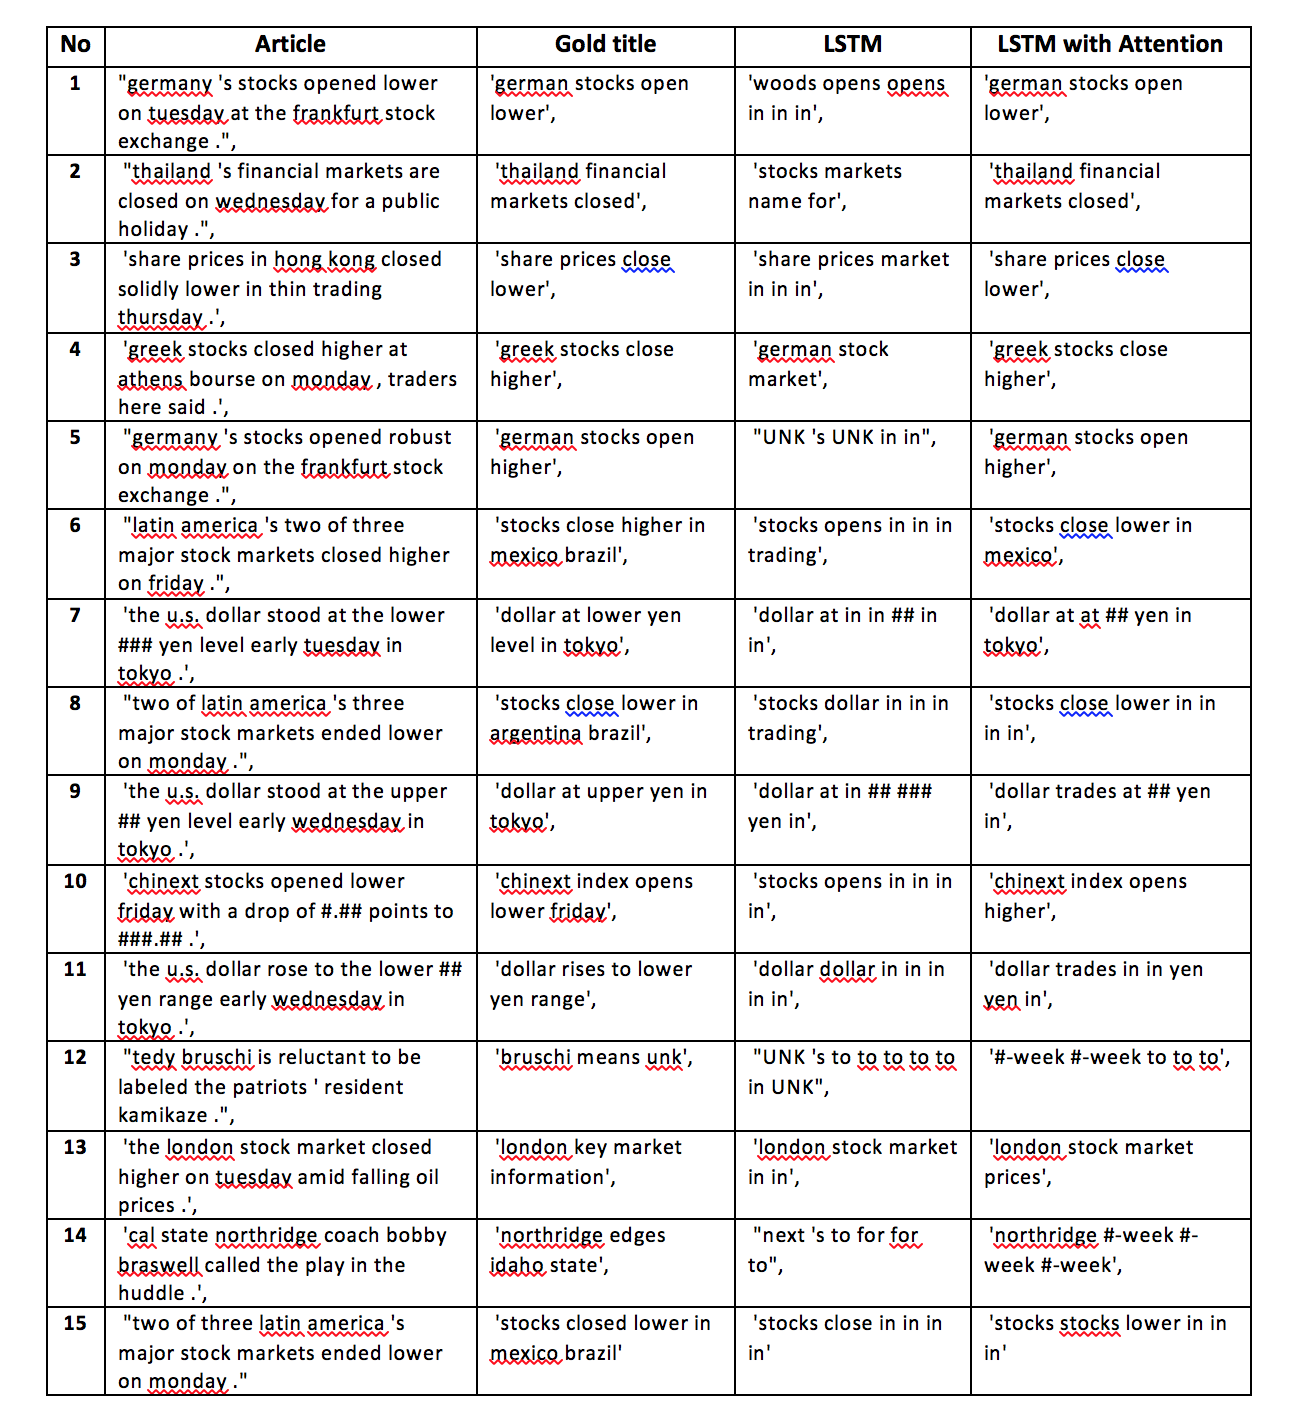

In [2]:
from IPython.display import Image
Image(filename='table.png')

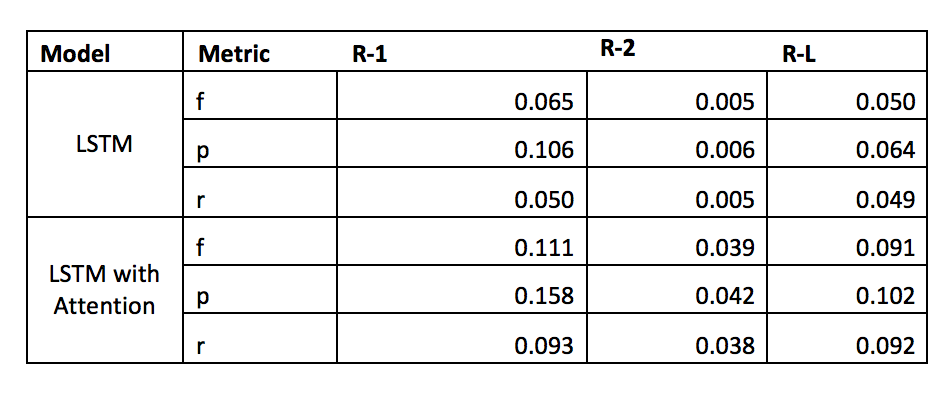

In [5]:
from IPython.display import Image
Image(filename='results.png')

**Discuss how the attention weights show whether the system is working for these examples (4-5 sentences, not including images or captions).**

The attention maps for 15 examples are shown above. The heatmap represents a soft alignment between the input (bottom) and the generated summary (left). The columns represent the distribution over the input after generating each word. The lighter the color the more related the word on the y-axis is with the word on the x-axis. The attention based model has produced good summaries for several examples on stocks. However, it makes several mistakes on stock related examples as well which have been highlighted above. 
Some interesting examples of high correlation between summary out put and input words is:
- stocks :greek,robust, frankfurt, america, close, closed, traders
- prices: shares, in, hong kong, lower, thin, trading
- financial: thailand, are, wednesday, closed

This seems to suggest that share, stocks, countries/places, certain verbs (closed, trading) seem closely associated
Some interesting examples of lower correlation are:
- stocks: two, on, chinext, monday
- the: london, us
- major: stocks, in, lower, close,

It seems like words like major show very low correlation with several other words in the text. This could be because major does not feature prominently in the training set like chinext.

Attention weights help analyze how well the model is learning. For example, the correlation between german and german is very low which suggests that the model is still faulty.



**Identify the problems that your system has the most trouble with. These may include repetition of words,
ungrammaticality, syntactic problems such as attachment which make the resulting summary syntactically
fluent but semantically incorrect, reference issues (e.g., using pronouns that are not resolved or NP
references that are incorrect), wrong phrases dropped from the sentence, improper handling of proper
nouns, etc. Also note how much abstraction vs. extraction your system does. Is your system making
lexical substitutions, generalizing, compressing? Compare your different system outputs to reveal the pros
and cons of each.**

The model still has low rouge scores and makes many mistakes (even though we have chosen to do a lot of our analysis on stock related articles). Some common problems with the system are:

- Repetition: This is a common problem which is more prominent without attention than with attention but still occurs. The model keeps repeating the same word in the summary and the sentence stops making sense both syntactically and semantically.

        - Article: 'the u.s. dollar rose to the lower ## yen range early wednesday in tokyo .'
        - Summary (without attention) 'dollar dollar in in in in in'
        - Summary:  'dollar trades in in yen yen in'


- Ungrammaticality and over-simplification: There is lot of ungramaticallity and syntactic mistakes. For a complicated example as given below both LSTM models with and without attention often even incomplete sentences as summaries as shown below. Also the models seem to be oversimplifying the summaries and often do not capture information that a human summarizer migh capture such as time information. The model also seems to be replacing numbers which again is a way of oversimplication.

        - Article:  'the london stock market closed higher on tuesday amid falling oil prices .
        - Summary (without attention) :  'london stock market in in'
        - Summary:   'london stock market prices'
        
- Unrelated summaries: In many cases especially for the basic model, it cannot capture more complex information from longer/comples articles and just predicts random unrelated workds and UNKs. With attention, the model does better but still can output completely irrelevant information as shown below.

        - Article: "tedy bruschi is reluctant to be labeled the patriots ' resident kamikaze ."
        - Summary (without attention) :  "UNK 's to to to to to in UNK"
        - Summary:  '#-week #-week to to to'
        
        - Article:  'cal state northridge coach bobby braswell called the play in the huddle .'
        - Summary (without attention) :   "next 's to for for to"
        - Summary:   'northridge #-week #-week #-week'


The model seems to be performing some abstractive summarization but also seems to produce many extractive summaries. In the following it has picked up 3 words which occur as is in the text. Also it has removed many words in the text. Thus it seems to be using extractive principles.

        - Article: germany 's stocks opened lower on tuesday at the frankfurt stock exchange
        - Summary: german stocks open lower

        - Article: 'greek stocks closed higher at athens bourse on monday , traders here said .'
        - Summary:  'greek stocks close higher'

However, there are many examples of abstraction as well in our examples. In the following the summarizer replaces latin america with mexico, stood at with trades

        - Article:  'the u.s. dollar stood at the upper ## yen level early wednesday in tokyo .'
        - Summary:   'dollar trades at ## yen in'

        - Article: "latin america 's two of three major stock markets closed higher on friday ."
        - Summary: 'stocks close lower in mexico'

The system is making lexical summarization (opened -> opens, closed -> close) and generalizing (latin america -> mexico). The differences between the models are apparent through  the examples. The plain LSTM model seems to struggle more with repetitions but there are repetitions in the attention based model too. There are more irrelevant summaries in the basic model as well but both face similar issues. Based on both literature and our own scores, it seems clar that the attention based model does better overall.

**Select one of the problems that you identified and provide a proposal for what you would do to correct the
problem. Suppose you were to either augment this model or re-do this in a traditional supervised approach
perhaps using parses of the input or pos tagging. For example, your augmentation may modify the output
of the LSTM to remove additional clauses. How would you approach this and what features would you
use? Be creative. Provide​ ​a​ ​1-3​ ​page​ ​description​.**


One of the major problems is ungrammaticality(syntactic errors) and oversimplification.Despite training for 150 epochs there are still many gibberish predictions even with attention (which has been shown to produce much better results in literature). This highlights the need for making changes to the architecture as well as incorporating other preprocessing and checking mechanisms instead of directly using a simple generic encoder-decoder framework. I think there is a lot of value in using an encoder-decoder framework, because using a completely data-driven approach we have been able to produce reasonable summaries for several articles. This is why I would choose to augment the model than use simpler supervised techniques.

It is interesting to see that this model does well on stock market related data even though specific mechanisms haven't been incorporated to facilitate this. This shows that there is a lot of domain-specific customization possible. For example, one way to augment this approach is to initially split up the training set into different domains and creating domain-specific vocabularies and models. This will help the model to learn the relationships better. The articles can be split by using some clustering algorithm like k-means or creating manual bag-of-words to assign labels. This will help solve problems of oversimplification as well as irrelevant summaries. Also the model will be able to learn better correlation which will help make it more abstractive and syntactically diverse. This will eventually help in creating more semantically consistent summaries.

Another way to address this issue is part-of-speech tagging on the input and to feed both pos tags as well as raw text as input to the model. The model will then learn correlations between not just word and word but also pos and pos and word and pos which could go a log way in making the predictions semantically and syntactically more consistent. 

A simpler way to incorporate pos tags and parsing structure is to repeatedly train the model. After an iteration of some epochs, we can generate prediction, evaluate their syntactic structure by parsing, score these and keep training the model further till we can cross a certain threshhold in terms of the prediction or some maximum no. of epochs that we can train for. 

Another simple way to take care of inefficiencies like repetitions is post-processing. For example, we can drop repeated words from predictions and keep only one for each unique word. Another way to take care of incomplete sentence preictions is to drop last words (for example, 'dollar trades at ## yen in'). If we drop dangling prepositions, it could make the summary more understandable.